<a href="https://colab.research.google.com/github/phamngochieu123456/HK_Race/blob/master/HK_Race_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [205]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.activations import softmax
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

# races.csv processing

## Raw data Profiling

In [206]:
raw_races_csv_data = pd.read_csv("/content/races.csv")

In [207]:
raw_races_csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6349 entries, 0 to 6348
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   race_id             6349 non-null   int64  
 1   date                6349 non-null   object 
 2   venue               6349 non-null   object 
 3   race_no             6349 non-null   int64  
 4   config              6349 non-null   object 
 5   surface             6349 non-null   int64  
 6   distance            6349 non-null   int64  
 7   going               6349 non-null   object 
 8   horse_ratings       6349 non-null   object 
 9   prize               5887 non-null   float64
 10  race_class          6349 non-null   int64  
 11  sec_time1           6349 non-null   float64
 12  sec_time2           6349 non-null   float64
 13  sec_time3           6349 non-null   float64
 14  sec_time4           3634 non-null   float64
 15  sec_time5           821 non-null    float64
 16  sec_ti

In [208]:
races_df = raw_races_csv_data[['race_id', 'venue', 'config', 'surface', 'distance', 'going', 'race_class', 'prize']].copy()

In [209]:
races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6349 entries, 0 to 6348
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   race_id     6349 non-null   int64  
 1   venue       6349 non-null   object 
 2   config      6349 non-null   object 
 3   surface     6349 non-null   int64  
 4   distance    6349 non-null   int64  
 5   going       6349 non-null   object 
 6   race_class  6349 non-null   int64  
 7   prize       5887 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 396.9+ KB


In [210]:
races_df.describe()

,race_id,surface,distance,race_class,prize
count,6349.000000,6349.000000,6349.000000,6349.000000,5.887000e+03
mean,3174.000000,0.109151,1419.113246,3.893684,1.134790e+06
std,1832.942761,0.311853,281.468745,1.992868,1.749156e+06
min,0.000000,0.000000,1000.000000,0.000000,4.850000e+05
25%,1587.000000,0.000000,1200.000000,3.000000,6.750000e+05
50%,3174.000000,0.000000,1400.000000,4.000000,8.400000e+05
75%,4761.000000,0.000000,1650.000000,4.000000,1.060000e+06
max,6348.000000,1.000000,2400.000000,13.000000,2.500000e+07


## Encoding

In [211]:
config_list = ['A', 'A+3', 'B', 'B+2', 'C', 'C+3']

def ordinal_encode_config(config):
    return config_list.index(config) + 1

races_df['encoded_config'] = races_df['config'].apply(ordinal_encode_config)

In [212]:
races_df = races_df.drop(['config'], axis = 1)

In [213]:
turf_track_going = ['GOOD TO FIRM', 'GOOD', 'GOOD TO YIELDING', 'YIELDING', 'YIELDING TO SOFT', 'SOFT']
all_weather_track_going = ['FAST', 'WET FAST', 'SLOW', 'WET SLOW']

In [214]:
def map_going_to_track(going):
    if going in turf_track_going:
        return 0
    elif going in all_weather_track_going:
        return 1
    else:
        return None

In [215]:
races_df['track'] = races_df['going'].apply(map_going_to_track)

In [216]:
def ordinal_encode_going(going):
    if going in turf_track_going:
        return turf_track_going.index(going) + 1
    elif going in all_weather_track_going:
        return all_weather_track_going.index(going) + 1
    else:
        return None

races_df['encoded_going'] = races_df['going'].apply(ordinal_encode_going)

In [217]:
races_df = races_df.drop(['going'], axis = 1)

In [218]:
venue_encoder = preprocessing.LabelEncoder()
races_df['encoded_venue'] = venue_encoder.fit_transform(races_df['venue'])

In [219]:
races_df = races_df.drop(['venue'], axis = 1)

In [220]:
races_df

,race_id,surface,distance,race_class,prize,encoded_config,track,encoded_going,encoded_venue
0,0,0,1400,5,485000.0,1,0,1,1
1,1,0,1200,5,485000.0,1,0,1,1
2,2,0,1400,4,625000.0,1,0,1,1
3,3,0,1200,1,1750000.0,1,0,1,1
4,4,0,1600,4,625000.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...
6344,6344,0,1400,1,2500000.0,1,0,2,1
6345,6345,0,1600,11,23000000.0,1,0,2,1
6346,6346,0,2000,11,25000000.0,1,0,2,1
6347,6347,0,1200,2,1750000.0,1,0,2,1


## Fill null

In [221]:
imputer = KNNImputer(n_neighbors=20)
races_df_numpy = imputer.fit_transform(races_df)

races_df = pd.DataFrame(data=races_df_numpy, columns=races_df.columns, index=races_df.index)

In [222]:
races_df.describe()

,race_id,surface,distance,race_class,prize,encoded_config,track,encoded_going,encoded_venue
count,6349.000000,6349.000000,6349.000000,6349.000000,6.349000e+03,6349.000000,6349.000000,6349.000000,6349.000000
mean,3174.000000,0.109151,1419.113246,3.893684,1.120982e+06,3.144747,0.026146,1.851473,0.630966
std,1832.942761,0.311853,281.468745,1.992868,1.687944e+06,1.920685,0.159582,0.667565,0.482581
min,0.000000,0.000000,1000.000000,0.000000,4.850000e+05,1.000000,0.000000,1.000000,0.000000
25%,1587.000000,0.000000,1200.000000,3.000000,6.750000e+05,1.000000,0.000000,1.000000,0.000000
50%,3174.000000,0.000000,1400.000000,4.000000,8.400000e+05,3.000000,0.000000,2.000000,1.000000
75%,4761.000000,0.000000,1650.000000,4.000000,1.060000e+06,5.000000,0.000000,2.000000,1.000000
max,6348.000000,1.000000,2400.000000,13.000000,2.500000e+07,6.000000,1.000000,6.000000,1.000000


## Visualization

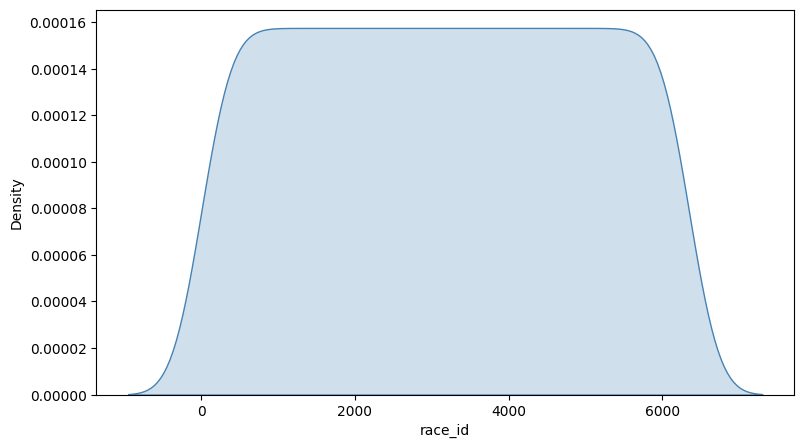

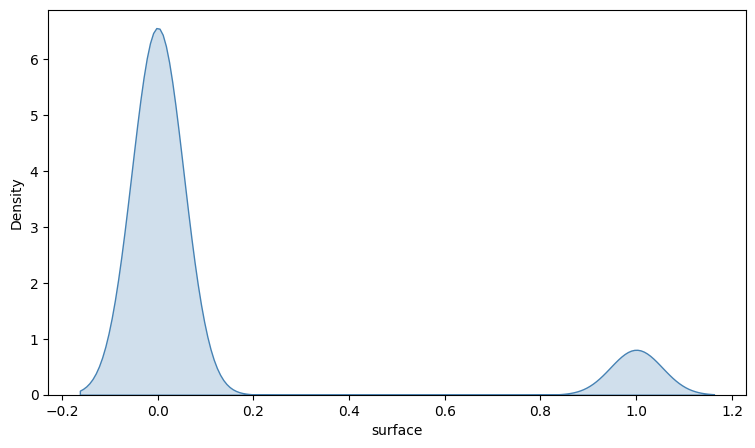

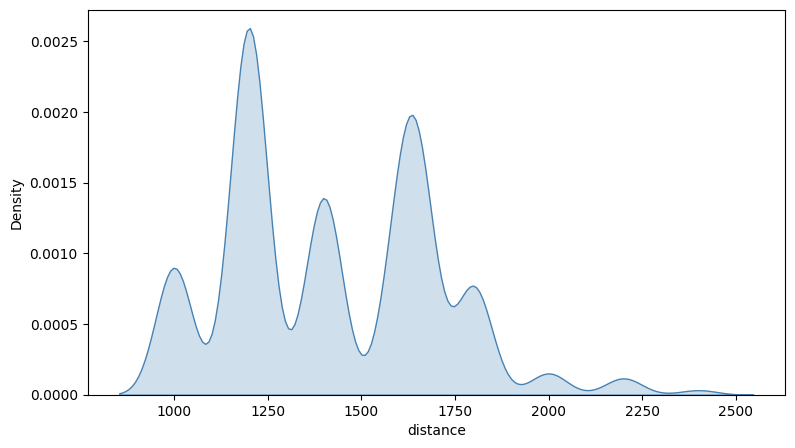

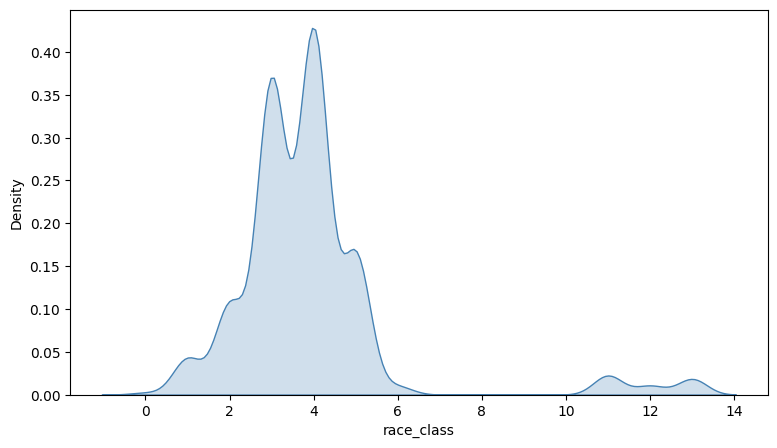

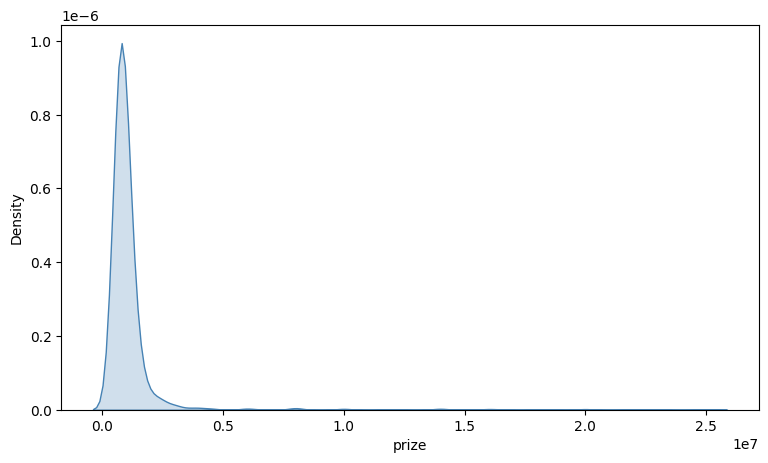

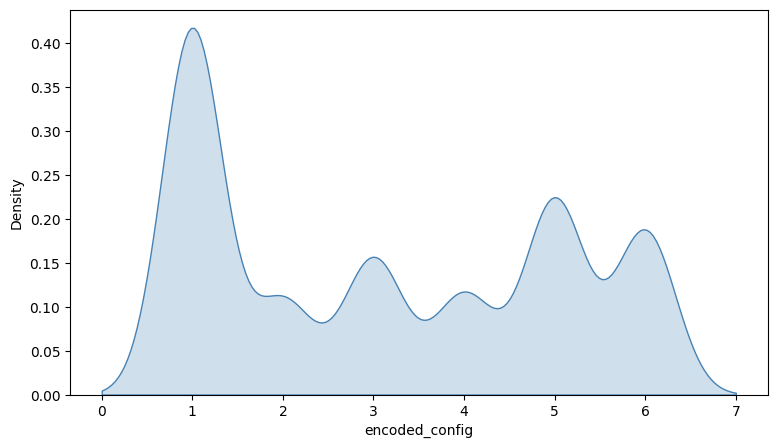

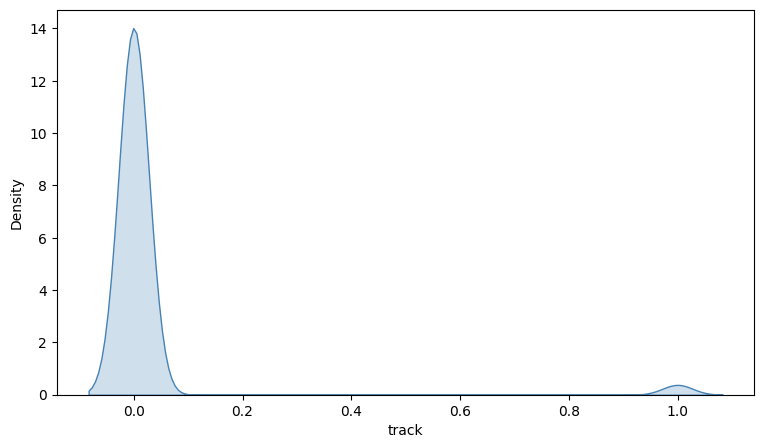

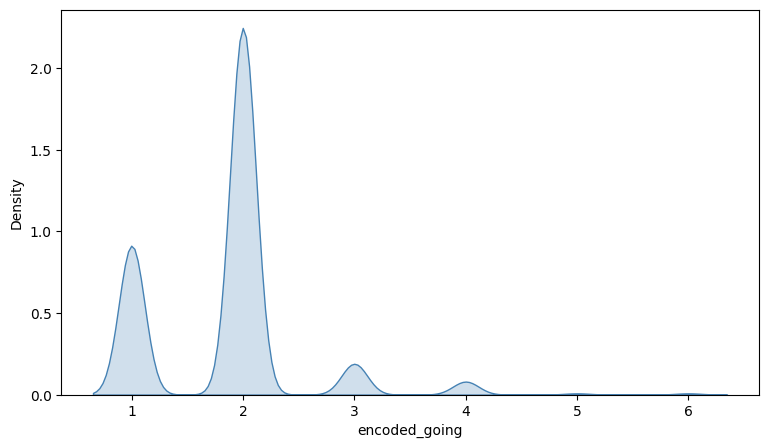

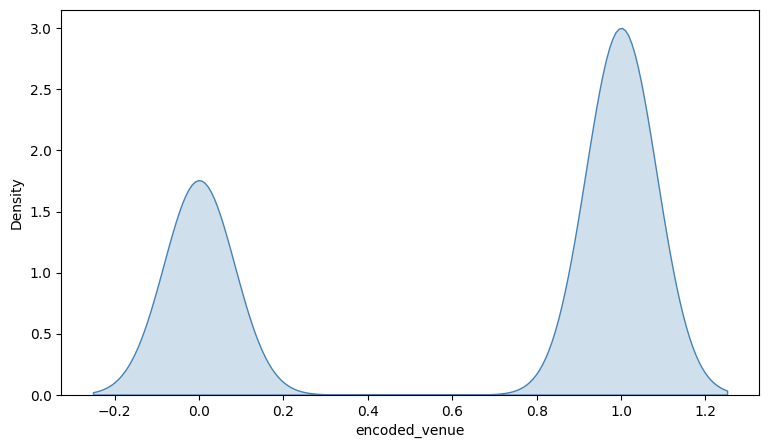

In [223]:
races_column_len = len(races_df.columns)

for i in range(races_column_len):
  plt.figure(figsize=(9, 5))
  sns.kdeplot(data=races_df[races_df.columns[i]], fill=True, color='steelblue')

# runs.csv processing

## Raw data Profiling

In [224]:
raw_runs_csv_data = pd.read_csv("/content/runs.csv")

In [225]:
raw_runs_csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   race_id          79447 non-null  int64  
 1   horse_no         79447 non-null  int64  
 2   horse_id         79447 non-null  int64  
 3   result           79447 non-null  int64  
 4   won              79447 non-null  float64
 5   lengths_behind   79447 non-null  float64
 6   horse_age        79447 non-null  int64  
 7   horse_country    79445 non-null  object 
 8   horse_type       79445 non-null  object 
 9   horse_rating     79447 non-null  int64  
 10  horse_gear       79447 non-null  object 
 11  declared_weight  79447 non-null  float64
 12  actual_weight    79447 non-null  int64  
 13  draw             79447 non-null  int64  
 14  position_sec1    79447 non-null  int64  
 15  position_sec2    79447 non-null  int64  
 16  position_sec3    79447 non-null  int64  
 17  position_sec

In [226]:
runs_df = raw_runs_csv_data[['race_id', 'draw', 'horse_age', 'horse_country', 'horse_type',
                   'horse_rating', 'declared_weight', 'actual_weight', 'win_odds',
                   'place_odds', 'result']].copy()

In [227]:
runs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   race_id          79447 non-null  int64  
 1   draw             79447 non-null  int64  
 2   horse_age        79447 non-null  int64  
 3   horse_country    79445 non-null  object 
 4   horse_type       79445 non-null  object 
 5   horse_rating     79447 non-null  int64  
 6   declared_weight  79447 non-null  float64
 7   actual_weight    79447 non-null  int64  
 8   win_odds         79447 non-null  float64
 9   place_odds       75712 non-null  float64
 10  result           79447 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 6.7+ MB


In [228]:
runs_df.describe()

,race_id,draw,horse_age,horse_rating,declared_weight,actual_weight,win_odds,place_odds,result
count,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,75712.000000,79447.000000
mean,3173.352814,6.876005,3.339346,61.034904,1104.953568,122.729656,28.812977,7.423177,6.838597
std,1833.101494,3.747589,0.876763,11.748788,62.347597,6.305496,30.097375,8.823430,3.730498
min,0.000000,1.000000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000
25%,1586.000000,4.000000,3.000000,60.000000,1062.000000,118.000000,7.700000,2.400000,4.000000
50%,3174.000000,7.000000,3.000000,60.000000,1102.000000,123.000000,15.000000,4.100000,7.000000
75%,4764.500000,10.000000,3.000000,60.000000,1146.000000,128.000000,38.000000,8.600000,10.000000
max,6348.000000,15.000000,10.000000,138.000000,1369.000000,133.000000,99.000000,101.000000,14.000000


## Drop the race has 15 horses

In [229]:
drop_index = runs_df[runs_df['race_id'] == 5188].index
runs_df = runs_df.drop(drop_index)

## Encoding

In [230]:
horse_country_columns = pd.get_dummies(runs_df['horse_country'])

In [231]:
runs_df = pd.concat([runs_df, horse_country_columns], axis = 1)

In [232]:
runs_df = runs_df.drop(['horse_country'], axis = 1)

In [233]:
horse_type_columns = pd.get_dummies(runs_df['horse_type'])

In [234]:
runs_df = pd.concat([runs_df, horse_type_columns], axis = 1)

In [235]:
runs_df = runs_df.drop(['horse_type'], axis = 1)

In [236]:
runs_df

,race_id,draw,horse_age,horse_rating,declared_weight,actual_weight,win_odds,place_odds,result,ARG,...,ZIM,Brown,Colt,Filly,Gelding,Grey,Horse,Mare,Rig,Roan
0,0,7,3,60,1020.0,133,9.7,3.7,10,0,...,0,0,0,0,1,0,0,0,0,0
1,0,12,3,60,980.0,133,16.0,4.9,8,0,...,0,0,0,0,1,0,0,0,0,0
2,0,8,3,60,1082.0,132,3.5,1.5,7,0,...,0,0,0,0,1,0,0,0,0,0
3,0,13,3,60,1118.0,127,39.0,11.0,9,0,...,0,0,0,0,1,0,0,0,0,0
4,0,14,3,60,972.0,131,50.0,14.0,6,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79442,6348,6,5,87,1191.0,122,99.0,NaN,6,0,...,0,0,0,0,1,0,0,0,0,0
79443,6348,4,5,84,1070.0,119,99.0,NaN,7,0,...,0,0,0,0,1,0,0,0,0,0
79444,6348,1,5,83,1148.0,120,99.0,NaN,10,0,...,0,0,0,0,1,0,0,0,0,0
79445,6348,12,3,82,1266.0,119,4.6,NaN,8,0,...,0,0,0,0,1,0,0,0,0,0


## Fill null

In [237]:
imputer_1 = KNNImputer(n_neighbors=20)
runs_df_numpy = imputer.fit_transform(runs_df)

runs_df = pd.DataFrame(data=runs_df_numpy, columns=runs_df.columns, index=runs_df.index)

In [238]:
runs_df.describe()

,race_id,draw,horse_age,horse_rating,declared_weight,actual_weight,win_odds,place_odds,result,ARG,...,ZIM,Brown,Colt,Filly,Gelding,Grey,Horse,Mare,Rig,Roan
count,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,...,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000
mean,3172.997734,6.875845,3.339330,61.033664,1104.949934,122.729898,28.812755,7.382356,6.838480,0.001599,...,0.000151,0.025732,0.003840,0.000541,0.950348,0.000214,0.013760,0.002996,0.001939,0.000604
std,1833.067877,3.747446,0.876743,11.749231,62.347180,6.305385,30.096684,8.718622,3.730432,0.039954,...,0.012290,0.158337,0.061847,0.023260,0.217226,0.014628,0.116494,0.054656,0.043989,0.024575
min,0.000000,1.000000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1585.000000,4.000000,3.000000,60.000000,1062.000000,118.000000,7.700000,2.400000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3174.000000,7.000000,3.000000,60.000000,1102.000000,123.000000,15.000000,4.100000,7.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4764.000000,10.000000,3.000000,60.000000,1146.000000,128.000000,38.000000,8.500000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6348.000000,14.000000,10.000000,138.000000,1369.000000,133.000000,99.000000,101.000000,14.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualization

<ipython-input-239-528a305caef5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9, 5))


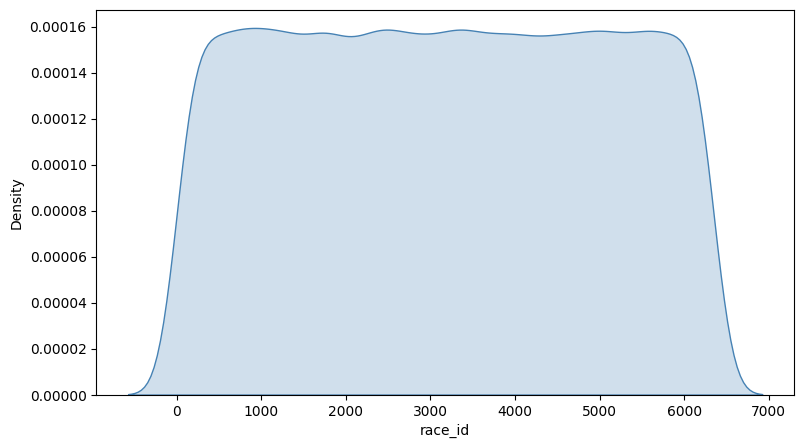

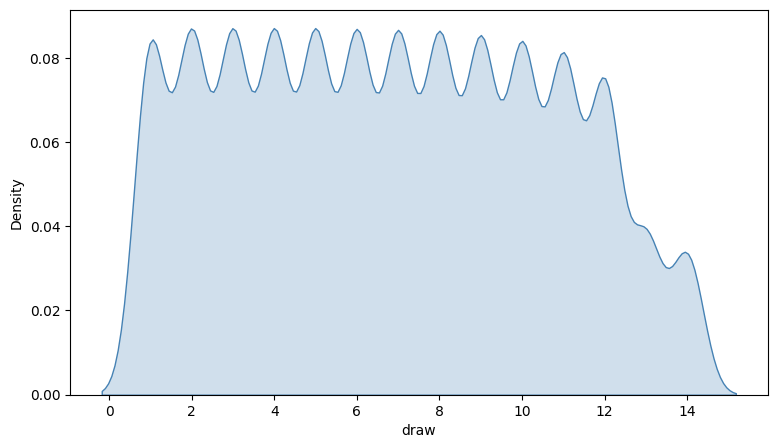

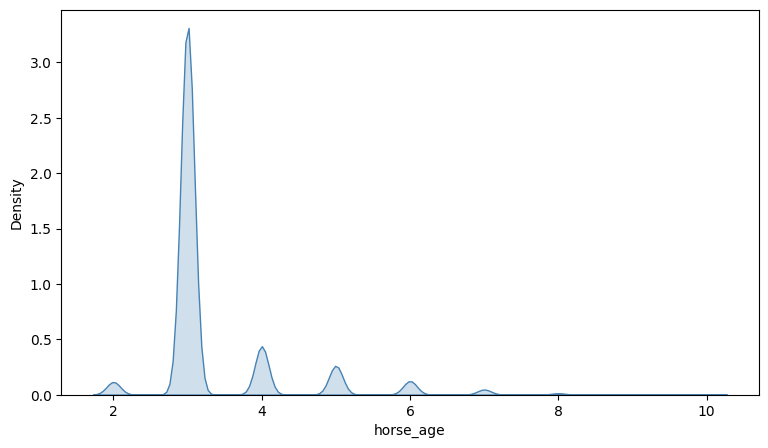

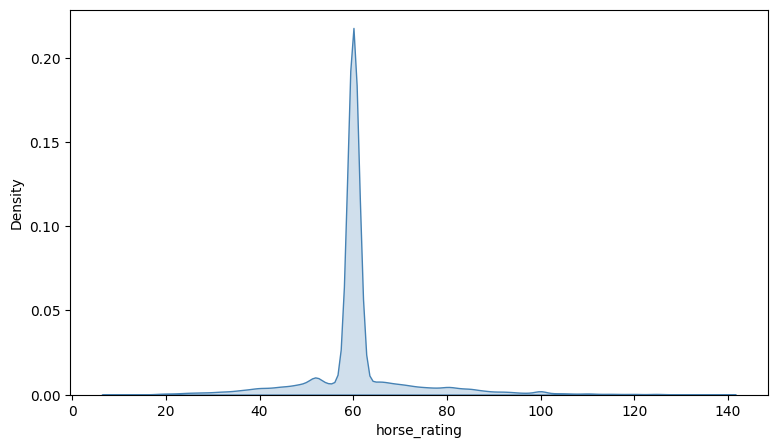

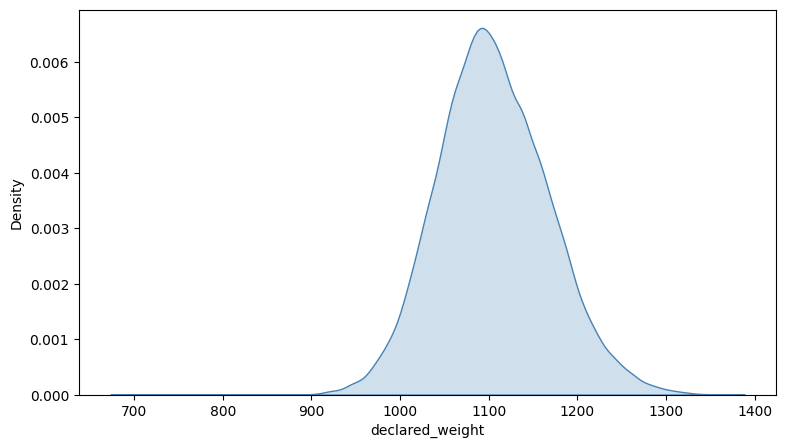

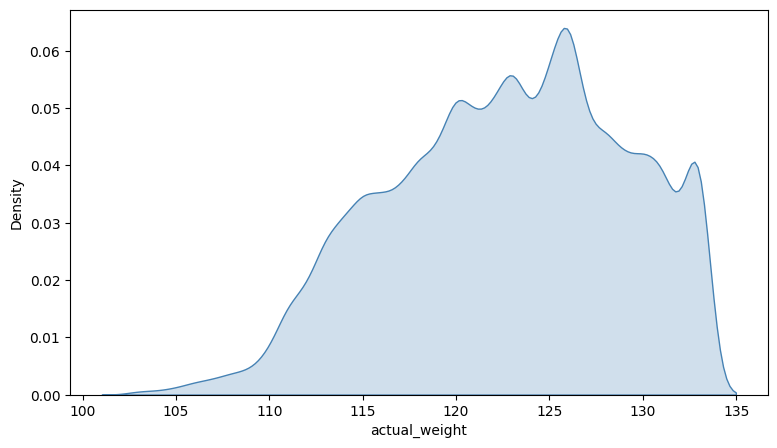

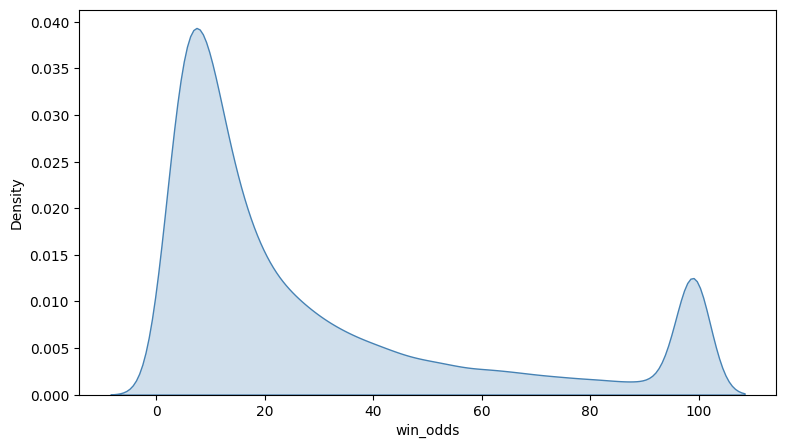

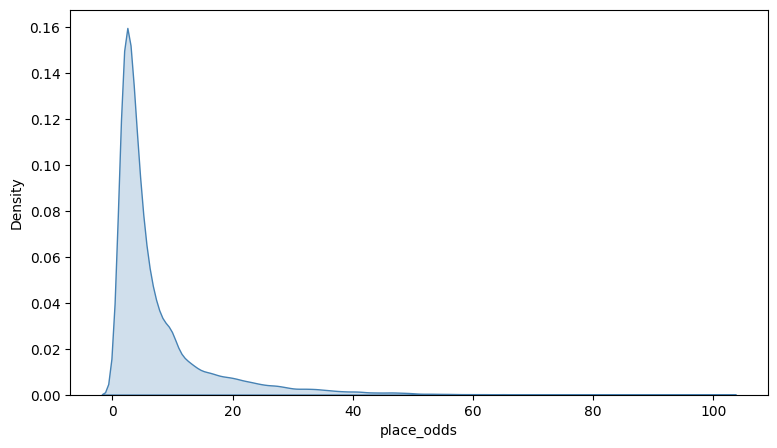

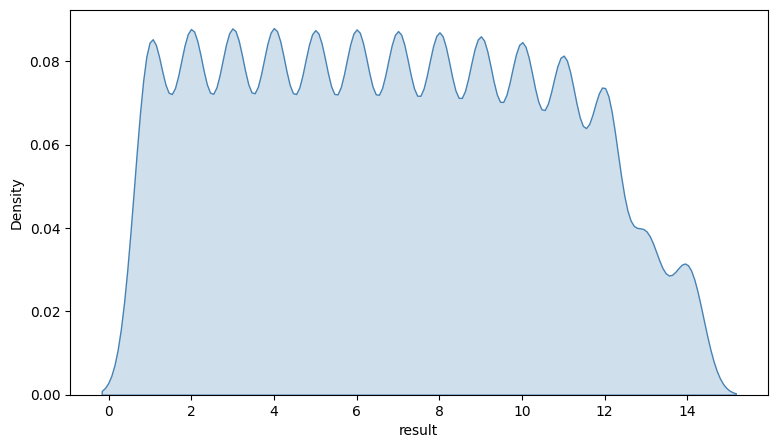

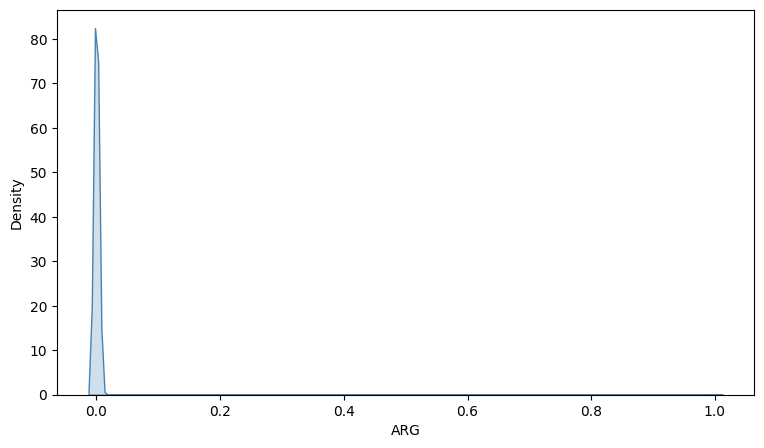

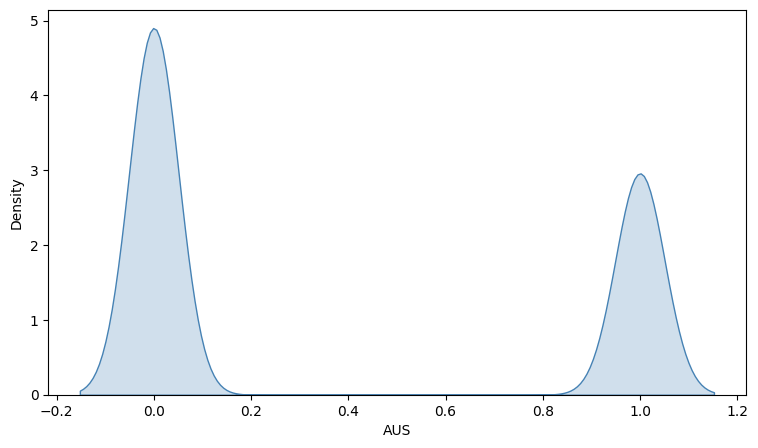

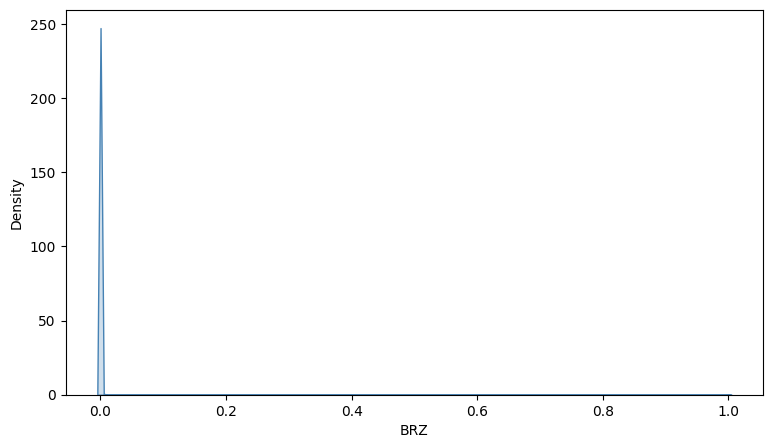

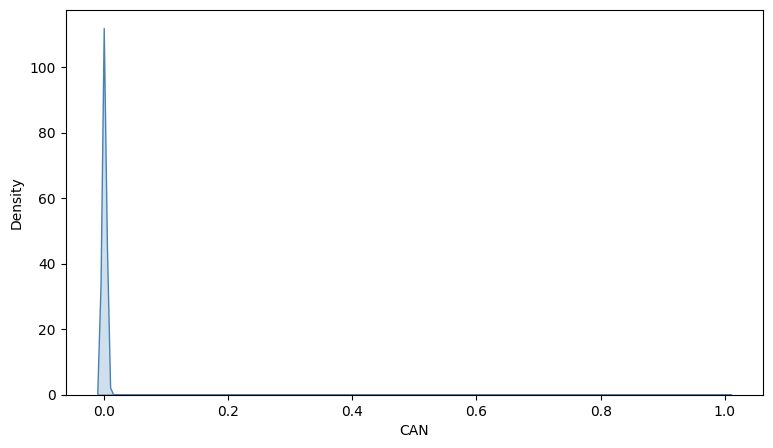

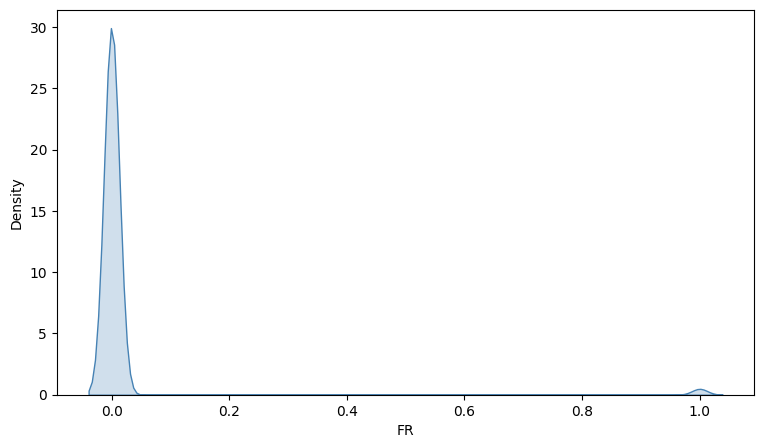

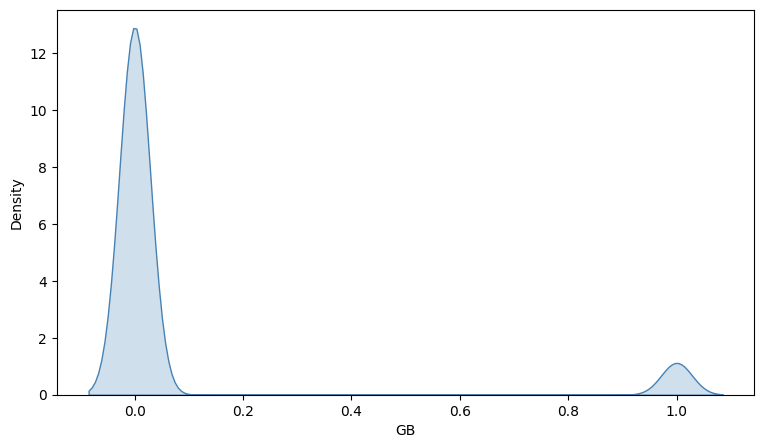

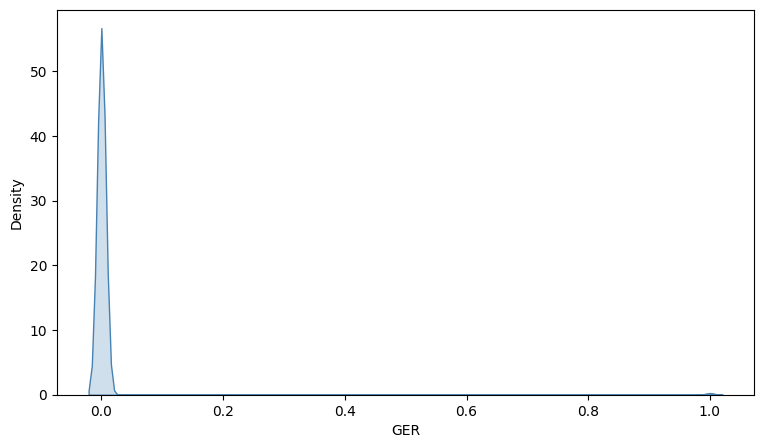

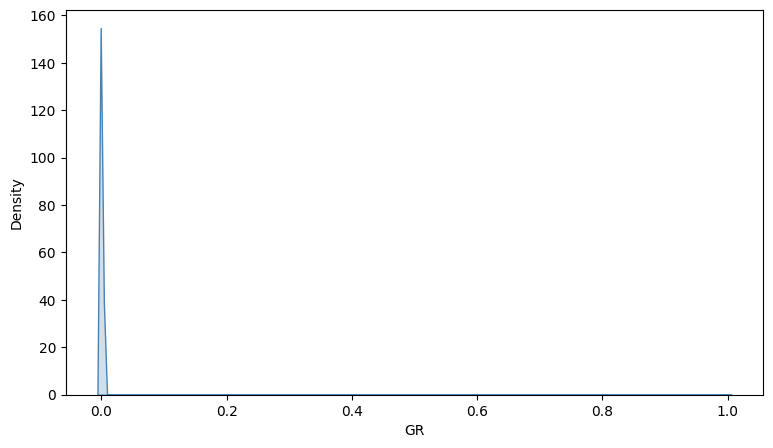

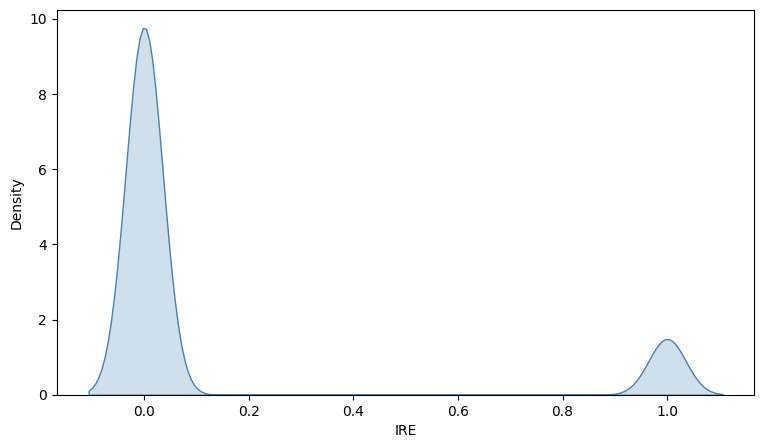

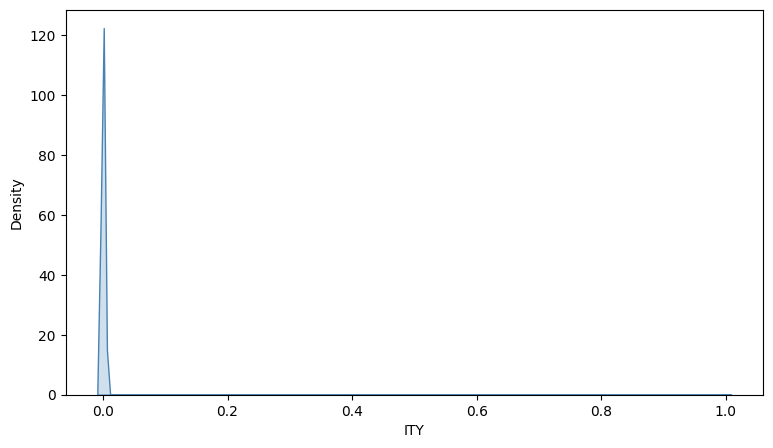

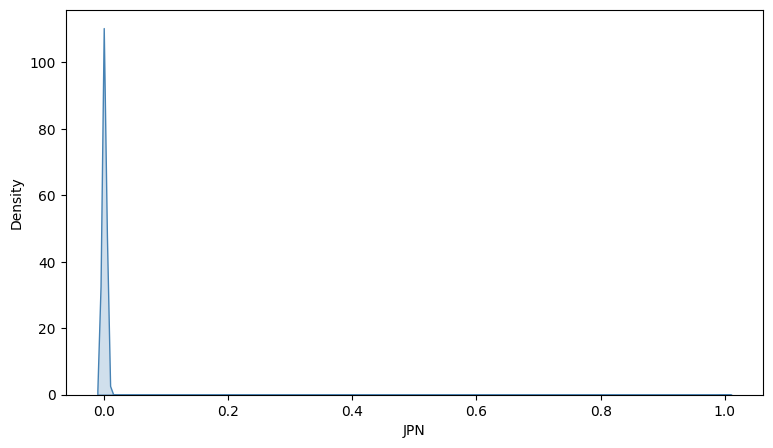

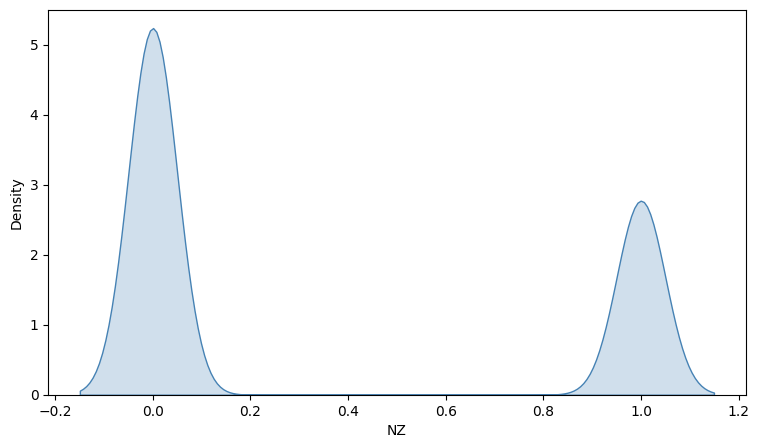

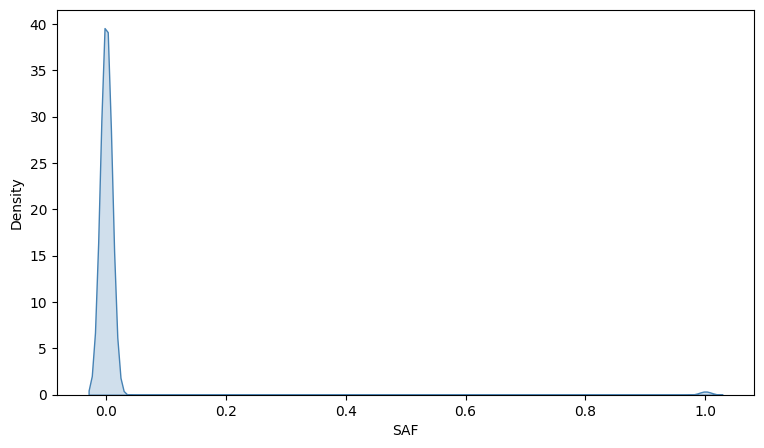

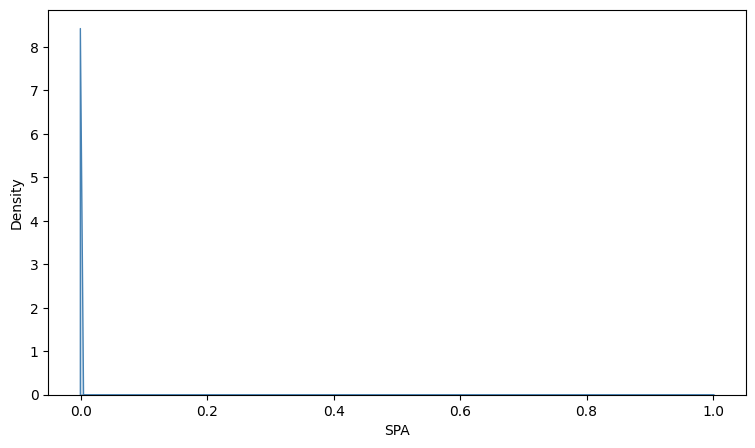

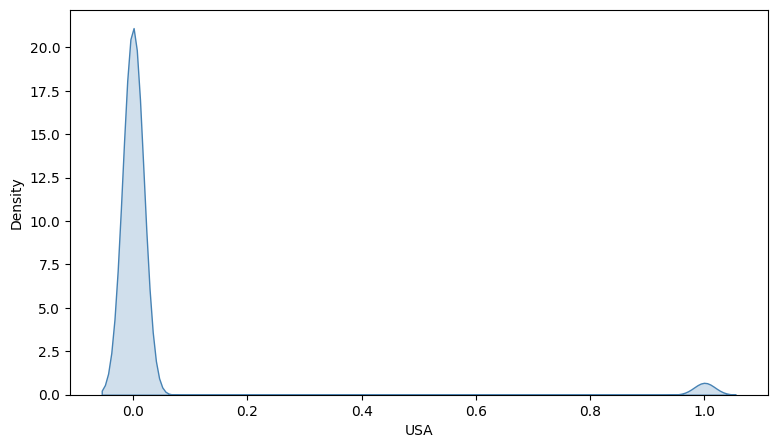

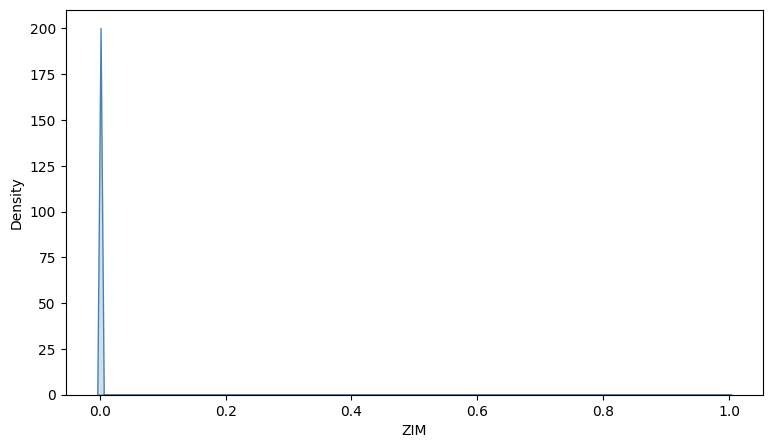

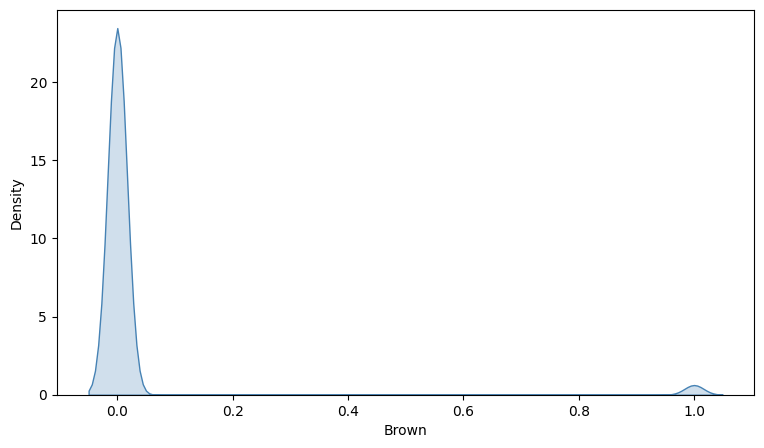

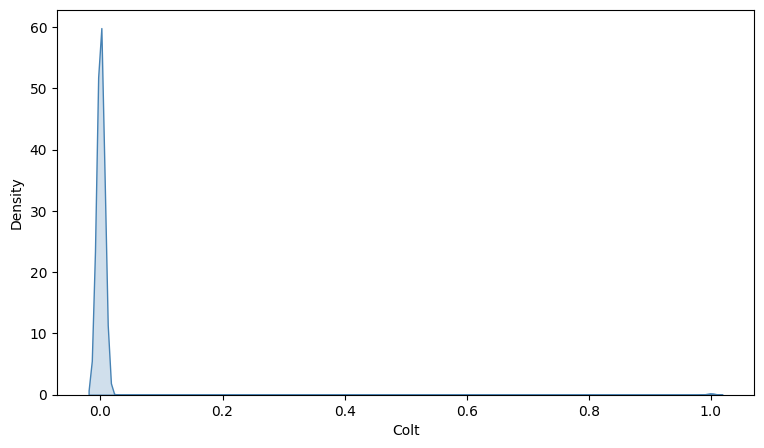

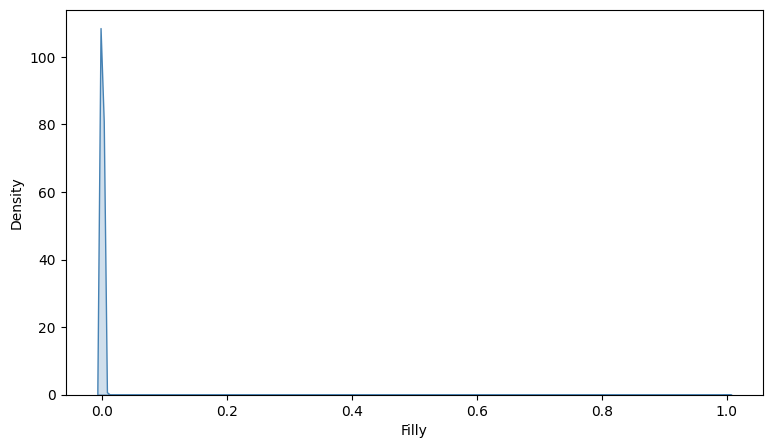

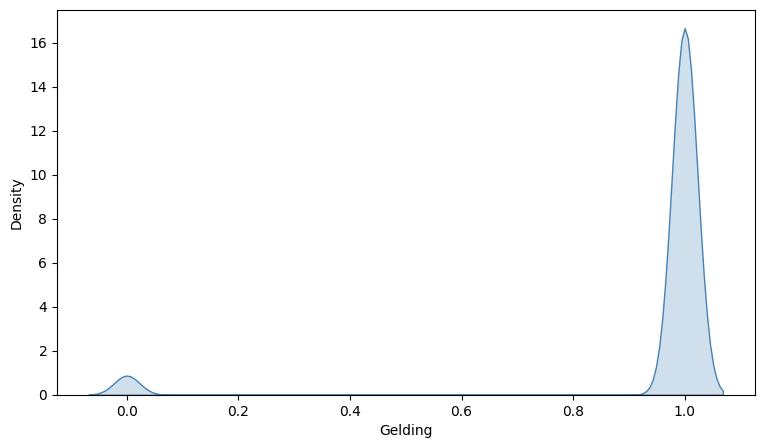

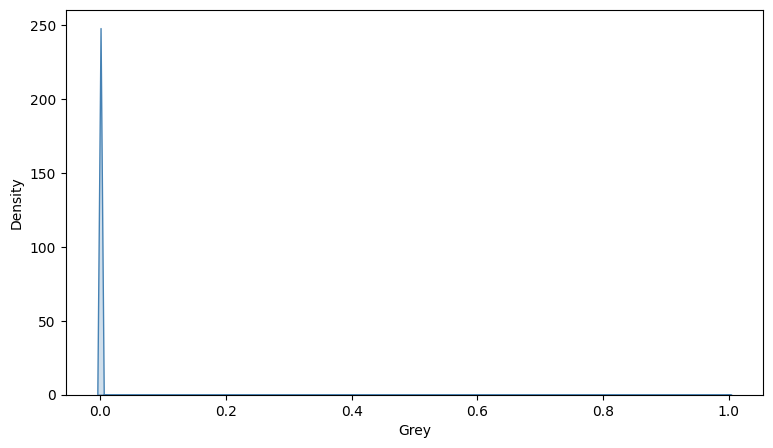

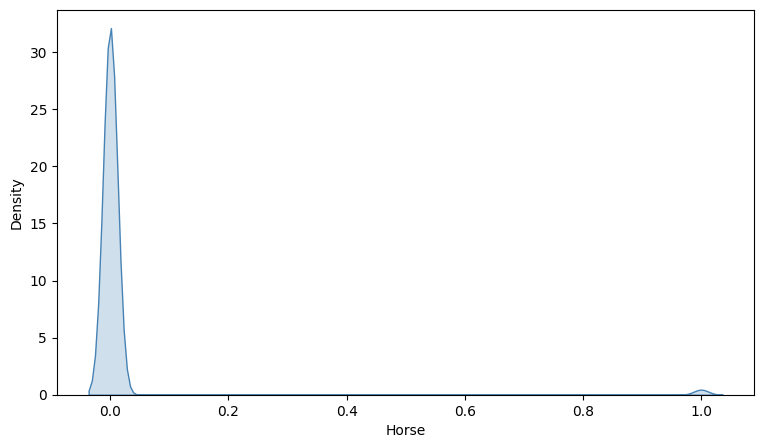

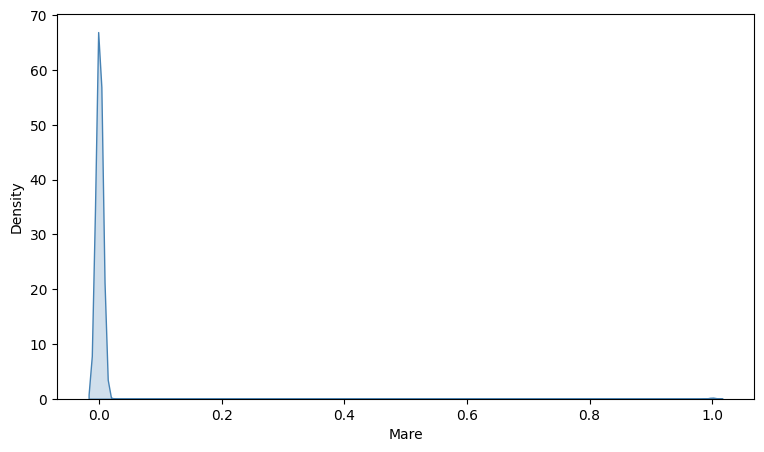

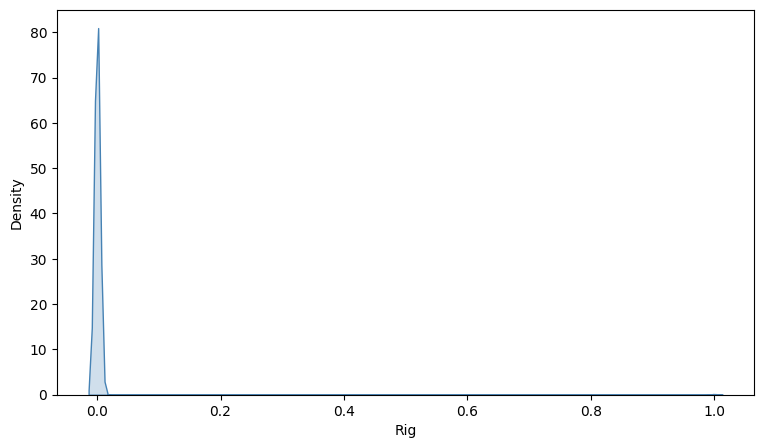

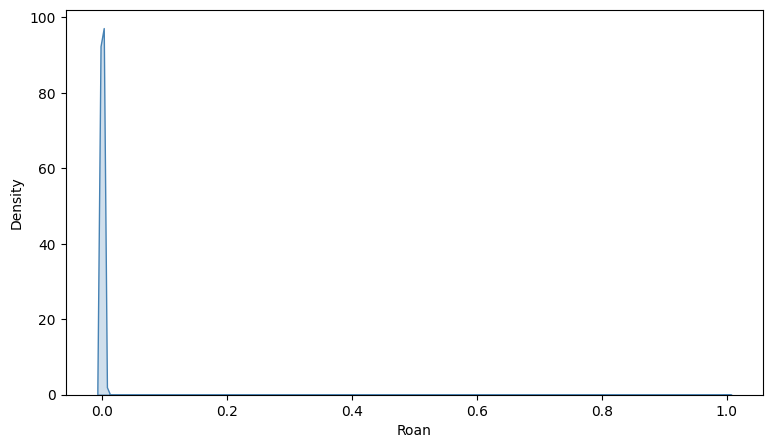

In [239]:
runs_column_len = len(runs_df.columns)

for i in range(runs_column_len):
  plt.figure(figsize=(9, 5))
  sns.kdeplot(data=runs_df[runs_df.columns[i]], fill=True, color='steelblue')

# Combine dataset

In [240]:
data = runs_df.merge(races_df, how='inner', on='race_id')

In [241]:
np.where(data.isnull())

(array([], dtype=int64), array([], dtype=int64))

<Axes: >

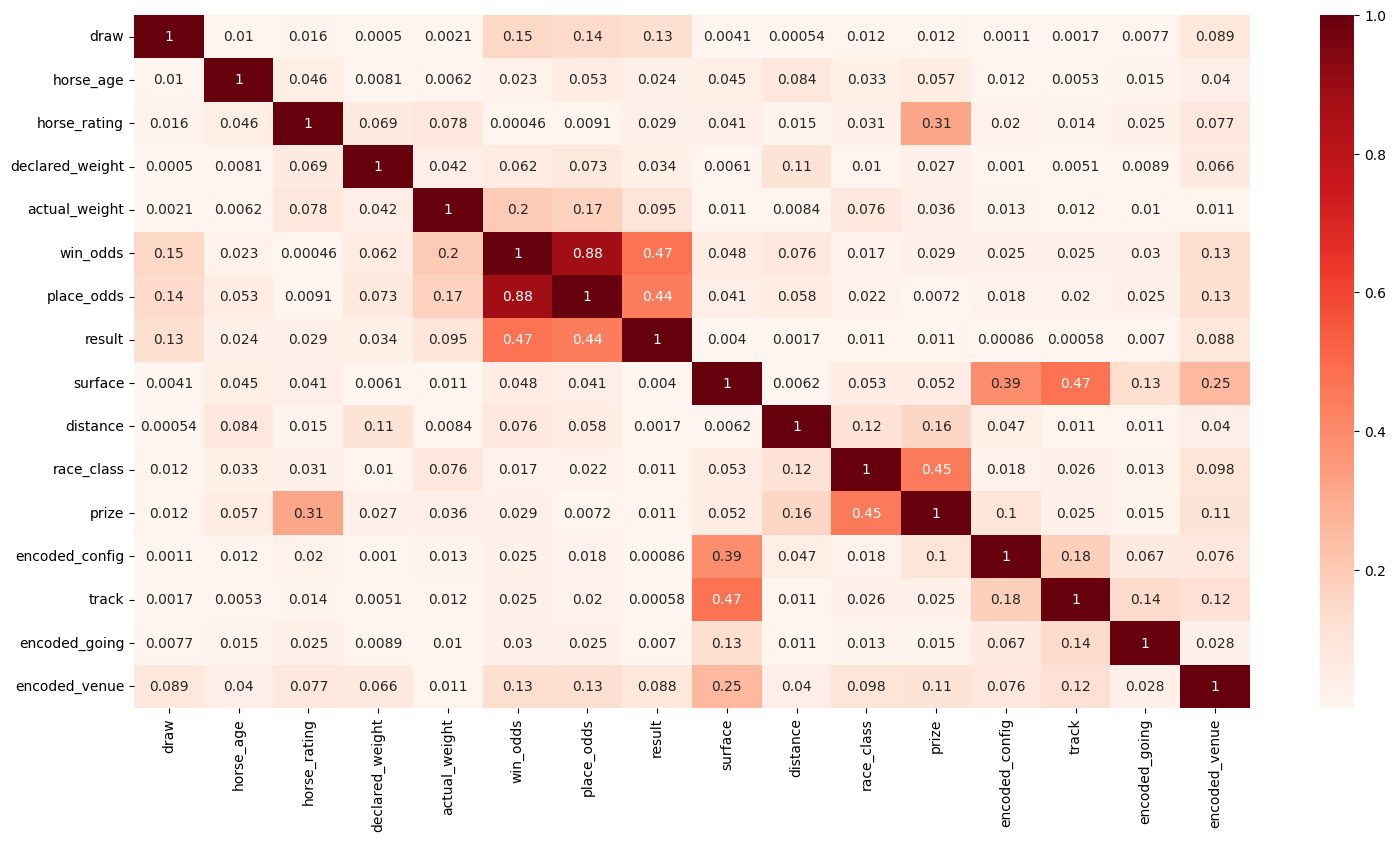

In [242]:
plt.figure(figsize=(18,9))
sns.heatmap(abs(data[['draw', 'horse_age', 'horse_rating', 'declared_weight',
       'actual_weight', 'win_odds', 'place_odds', 'result', 'surface', 'distance',
        'race_class', 'prize', 'encoded_config', 'track', 'encoded_going',
                      'encoded_venue']].corr()),cmap = "Reds", annot=True,)

# Ranking

## Trainning Model

In [243]:
use_column = ['race_id', 'result', 'place_odds']
use_column_pre = ['result', 'place_odds']

In [244]:
gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 42).split(data, groups=data['race_id'])

X_train_inds, X_test_inds = next(gss)

train_data= data.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(use_column)]
y_train = train_data.loc[:, train_data.columns.isin(['result'])]

groups = train_data.groupby('race_id').size().to_frame('size')['size'].to_numpy()

test_data= data.iloc[X_test_inds]

X_test = test_data.loc[:, ~test_data.columns.isin(use_column)]
y_test = test_data.loc[:, test_data.columns.isin(['result'])]

In [245]:
X_train

,draw,horse_age,horse_rating,declared_weight,actual_weight,win_odds,ARG,AUS,BRZ,CAN,...,Rig,Roan,surface,distance,race_class,prize,encoded_config,track,encoded_going,encoded_venue
0,7.0,3.0,60.0,1020.0,133.0,9.7,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1400.0,5.0,485000.0,1.0,0.0,1.0,1.0
1,12.0,3.0,60.0,980.0,133.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1400.0,5.0,485000.0,1.0,0.0,1.0,1.0
2,8.0,3.0,60.0,1082.0,132.0,3.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1400.0,5.0,485000.0,1.0,0.0,1.0,1.0
3,13.0,3.0,60.0,1118.0,127.0,39.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1400.0,5.0,485000.0,1.0,0.0,1.0,1.0
4,14.0,3.0,60.0,972.0,131.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1400.0,5.0,485000.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79428,6.0,5.0,87.0,1191.0,122.0,99.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1600.0,2.0,1750000.0,1.0,0.0,2.0,1.0
79429,4.0,5.0,84.0,1070.0,119.0,99.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1600.0,2.0,1750000.0,1.0,0.0,2.0,1.0
79430,1.0,5.0,83.0,1148.0,120.0,99.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1600.0,2.0,1750000.0,1.0,0.0,2.0,1.0
79431,12.0,3.0,82.0,1266.0,119.0,4.6,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1600.0,2.0,1750000.0,1.0,0.0,2.0,1.0


In [246]:
model = xgb.XGBRanker(
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.8,
    eta=0.05,
    max_depth=6,
    n_estimators=200,
    subsample=0.75
    )

model.fit(X_train, y_train,
          group=groups,
          verbose=True,
          feature_weights=[1, 1, 1, 1, 1, 0.5])

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.8,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=200, n_jobs=None,
          num_parallel_tree=None, predictor=None, ...)

## Predict

In [247]:
def predict(model, df):
    array = model.predict(df.loc[:, ~df.columns.isin(['race_id'])])
    return array.argsort().argsort() + 1

In [248]:
predictions_train = (
    train_data.loc[:, ~train_data.columns.isin(use_column_pre)]
    .groupby('race_id').apply(lambda x: predict(model, x)))

y_true_train = train_data.loc[:, train_data.columns.isin(['race_id', 'result'])]
y_true_train = y_true_train.groupby('race_id').apply(lambda x: x['result'].to_numpy(dtype=int))

predictions_test = (
    test_data.loc[:, ~test_data.columns.isin(use_column_pre)]
    .groupby('race_id').apply(lambda x: predict(model, x)))

y_true_test = test_data.loc[:, test_data.columns.isin(['race_id', 'result'])]
y_true_test = y_true_test.groupby('race_id').apply(lambda x: x['result'].to_numpy(dtype=int))

## Meansure

In [249]:
def top3_error(y_true, predictions):
    correct_idxs = []
    wrong_idxs = []
    total_races = len(y_true)
    correct_predictions = 0

    for race_id, true_positions in y_true.items():
        true_pos = np.where(true_positions == 1)[0][0]
        top3_pred = predictions[race_id].argsort()[:3]
        if true_pos in top3_pred:
            correct_predictions += 1
            correct_idxs.append(race_id)
        else:
            wrong_idxs.append(race_id)

    top3_error = correct_predictions / total_races
    return top3_error, correct_idxs, wrong_idxs

In [250]:
top3_error_train, correct_idxs_train, wrong_idxs_train = top3_error(y_true_train, predictions_train)
top3_error_test, correct_idxs_test, wrong_idxs_test = top3_error(y_true_test, predictions_test)
print(f"Top-3 Error Train: {top3_error_train:.4f}")
print(f"Top-3 Error Test: {top3_error_test:.4f}")

Top-3 Error Train: 0.6277
Top-3 Error Test: 0.6134


In [251]:
def top3_ordered(y_true, predictions):
    total_races = len(y_true)
    correct_predictions = 0

    for race_id, true_positions in y_true.items():
        top3_true = true_positions.argsort()[:3]
        top3_pred = predictions[race_id].argsort()[:3]
        if (top3_true == top3_pred).all():
            correct_predictions += 1

    top3_error = correct_predictions / total_races
    return top3_error

In [252]:
top3_ordered_train = top3_ordered(y_true_train, predictions_train)
top3_ordered_test = top3_ordered(y_true_test, predictions_test)
print(f"Top-3 Ordered Train: {top3_ordered_train:.4f}")
print(f"Top-3 Ordered Test: {top3_ordered_train:.4f}")

Top-3 Ordered Train: 0.0219
Top-3 Ordered Test: 0.0219


In [253]:
def top3_unordered(y_true, predictions):
    total_races = len(y_true)
    correct_predictions = 0

    for race_id, true_positions in y_true.items():
        top3_true = true_positions.argsort()[:3]
        top3_pred = predictions[race_id].argsort()[:3]
        if set(top3_true).issubset(set(top3_pred)):
            correct_predictions += 1

    top3_error = correct_predictions / total_races
    return top3_error

In [254]:
top3_unordered_train = top3_unordered(y_true_train, predictions_train)
top3_unordered_test = top3_unordered(y_true_test, predictions_test)
print(f"Top-3 Unordered Train: {top3_unordered_train:.4f}")
print(f"Top-3 Unordered Test: {top3_unordered_train:.4f}")

Top-3 Unordered Train: 0.0859
Top-3 Unordered Test: 0.0859


In [255]:
def top6(y_true, predictions):
    total_races = len(y_true)
    correct_predictions = 0

    for race_id, true_positions in y_true.items():
        top3_true = true_positions.argsort()[:6]
        top3_pred = predictions[race_id].argsort()[:3]
        if set(top3_pred).issubset(set(top3_true)):
            correct_predictions += 1

    top3_error = correct_predictions / total_races
    return top3_error

In [256]:
top6_train = top6(y_true_train, predictions_train)
top6_test = top6(y_true_test, predictions_test)
print(f"Top6 Train: {top6_train:.4f}")
print(f"Top6 Test: {top6_test:.4f}")

Top6 Train: 0.4589
Top6 Test: 0.4087


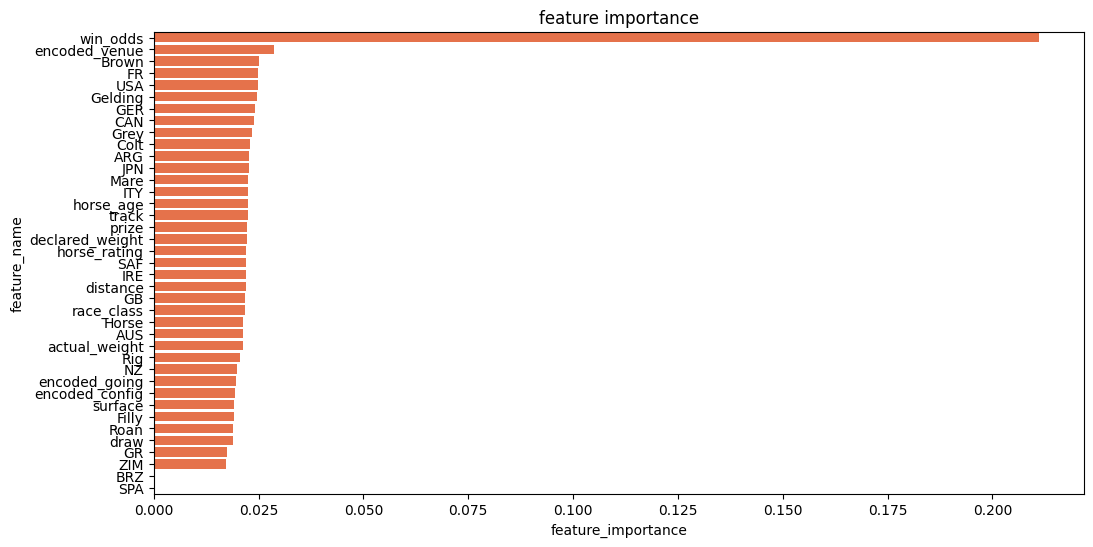

In [257]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()

In [258]:
true_idxs = np.random.choice(len(correct_idxs_test), 3, replace=False)
false_idxs = np.random.choice(len(wrong_idxs_test), 3, replace=False)

correct_idxs_test = np.array(correct_idxs_test)
wrong_idxs_test = np.array(wrong_idxs_test)

In [259]:
y_true_test.iloc[np.where(predictions_test.index.isin(correct_idxs_test[true_idxs]) == True)[0]]

race_id
228.0     [1, 9, 12, 5, 7, 2, 13, 10, 11, 6, 3, 8, 4]
2348.0        [7, 10, 9, 12, 3, 6, 8, 4, 5, 1, 2, 11]
2357.0        [7, 2, 6, 9, 8, 10, 5, 4, 11, 1, 3, 12]
dtype: object

In [260]:
predictions_test.iloc[np.where(predictions_test.index.isin(correct_idxs_test[true_idxs]) == True)[0]]

race_id
228.0     [1, 4, 11, 6, 7, 3, 8, 12, 10, 9, 2, 13, 5]
2348.0        [6, 9, 7, 12, 8, 5, 11, 4, 1, 3, 2, 10]
2357.0        [2, 4, 3, 9, 12, 6, 5, 10, 8, 1, 7, 11]
dtype: object

In [261]:
data.iloc[np.where(data['race_id'].isin(correct_idxs_test[true_idxs]) == True)[0]][['race_id', 'win_odds', 'result']]

,race_id,win_odds,result
2843,228.0,2.3,1.0
2844,228.0,15.0,9.0
2845,228.0,38.0,12.0
2846,228.0,19.0,5.0
2847,228.0,22.0,7.0
2848,228.0,8.3,2.0
2849,228.0,23.0,13.0
2850,228.0,40.0,10.0
2851,228.0,39.0,11.0
2852,228.0,23.0,6.0


In [262]:
y_true_test.iloc[np.where(predictions_test.index.isin(wrong_idxs_test[false_idxs]) == True)[0]]

race_id
1562.0    [7, 3, 9, 6, 4, 14, 1, 8, 12, 2, 5, 10, 13, 11]
2228.0    [12, 11, 6, 2, 9, 10, 5, 3, 14, 13, 7, 8, 4, 1]
5928.0                        [6, 7, 8, 2, 1, 5, 3, 4, 9]
dtype: object

In [263]:
predictions_test.iloc[np.where(predictions_test.index.isin(wrong_idxs_test[false_idxs]) == True)[0]]

race_id
1562.0    [1, 8, 3, 7, 6, 13, 4, 11, 9, 5, 2, 12, 14, 10]
2228.0    [2, 11, 8, 1, 5, 12, 13, 10, 14, 3, 4, 7, 9, 6]
5928.0                        [2, 1, 7, 3, 4, 5, 9, 8, 6]
dtype: object

In [264]:
data.iloc[np.where(data['race_id'].isin(wrong_idxs_test[false_idxs]) == True)[0]][['race_id', 'win_odds', 'result']]

,race_id,win_odds,result
19556,1562.0,3.2,7.0
19557,1562.0,32.0,3.0
19558,1562.0,4.8,9.0
19559,1562.0,16.0,6.0
19560,1562.0,17.0,4.0
19561,1562.0,99.0,14.0
19562,1562.0,10.0,1.0
19563,1562.0,65.0,8.0
19564,1562.0,39.0,12.0
19565,1562.0,13.0,2.0
